## Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## System Parameters

In [2]:
np.random.seed(42)

N_UE = 3                     # Number of User Equipments
N_EDGE = 2                   # Number of Edge Servers
N_TIME_SLOT = 200            # Number of time slots
DURATION_S = 1.0             # Duration of one time slot in seconds

UE_COMP_CAP = 2.6            # Local CPU (GHz)
UE_COMP_POWER = 1.5          # Local computation power (W)
UE_TX_POWER = 3.5            # Transmission power (W)
UE_TX_RATE = 14.0            # Transmission Rate (Mbps)

EDGE_COMP_CAP = 41.8         # Edge Server CPU (GHz)

TASK_COMP_DENS = 0.397       # Task Density (Gcycles/Mbits)
TASK_MIN_SIZE = 1.0          # Mbits
TASK_MAX_SIZE = 7.0          # Mbits

## System Environment

In [3]:
class Environment:
    def __init__(self, n_ue, n_edge, n_time_slot, duration):
        self.n_ue = n_ue
        self.n_edge = n_edge
        self.n_time = n_time_slot
        self.duration = duration
        self.time_count = 0
        
        self.backlog_ue = np.zeros(n_ue)
        self.backlog_edge = np.zeros(n_edge)
        
        self.history = []

    def reset(self):
        self.time_count = 0
        self.backlog_ue.fill(0.0)
        self.backlog_edge.fill(0.0)
        self.history = []
        return self.get_states()

    def get_states(self, task_sizes=None):
        """
        State for each UE: [Task Size, Local Backlog, Server 1 Backlog, Server 2 Backlog]
        """
        if task_sizes is None:
            task_sizes = np.zeros(self.n_ue)
            
        states = []
        for i in range(self.n_ue):
            s = [task_sizes[i], self.backlog_ue[i], self.backlog_edge[0], self.backlog_edge[1]]
            states.append(s)
        return states

    def step(self, actions, task_sizes):
        """
        actions: list of ints [0, 1, 2] for each UE
        task_sizes: list of floats (Mbits) for current slot
        """
        self.backlog_ue = np.maximum(0, self.backlog_ue - self.duration)
        self.backlog_edge = np.maximum(0, self.backlog_edge - self.duration)
        
        total_delay_slot = 0
        total_energy_slot = 0
        
        for i in range(self.n_ue):
            action = actions[i]
            size_mb = task_sizes[i]
            load_gc = size_mb * TASK_COMP_DENS
            
            delay = 0
            energy = 0
            
            if action == 0: # LOCAL
                proc_time = load_gc / UE_COMP_CAP
                
                # Delay = Local Wait + Local Proc
                delay = self.backlog_ue[i] + proc_time
                energy = proc_time * UE_COMP_POWER
                
                self.backlog_ue[i] += proc_time
                
            else: # OFFLOAD (Action 1 or 2)
                server_idx = action - 1
                
                tx_time = size_mb / UE_TX_RATE
                edge_proc_time = load_gc / EDGE_COMP_CAP
                
                # Delay = Transmission + Server Wait + Server Proc
                delay = tx_time + self.backlog_edge[server_idx] + edge_proc_time
                energy = tx_time * UE_TX_POWER
                
                self.backlog_edge[server_idx] += edge_proc_time

            total_delay_slot += delay
            total_energy_slot += energy
        
        self.time_count += 1
        done = self.time_count >= self.n_time
        
        self.history.append([total_delay_slot, total_energy_slot])
        
        return self.get_states(task_sizes), total_delay_slot, total_energy_slot, done

## Baselines

In [4]:
class RandomAgent:
    def get_action(self, state):
        return np.random.choice([0, 1, 2])

class LocalOnlyAgent:
    def get_action(self, state):
        return 0

## Task: Fuzzy Logic Controller

In [ ]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl


class FuzzyAgent:
    def __init__(self):
        """
        You must implement a Mamdani-type fuzzy controller that decides:
            0 = local execution
            1 = offload to server 1
            2 = offload to server 2

        INPUTS (provided by environment):
            task_size      : [0, 7]
            local_queue    : [0, 3]
            edge_queue     : [0, 1]   (min of the two server queues)

        OUTPUT:
            offload_pref   : [0, 100]
                <= 50  → choose local
                >  50 → offload to least-loaded server

        Your tasks:
            - Define fuzzy antecedents and their membership functions
            - Define the fuzzy consequent and its membership functions
            - Design a meaningful rule base
            - Create a ControlSystem and ControlSystemSimulation
        """

        # =====================================
        # Define fuzzy input variables
        # =====================================
        task_size = ctrl.Antecedent(np.arange(0, 7.1, 0.1), "task_size")
        local_queue = ctrl.Antecedent(np.arange(0, 3.1, 0.1), "local_queue")
        edge_queue = ctrl.Antecedent(np.arange(0, 1.1, 0.05), "edge_queue")

        # =====================================
        # Define fuzzy output variable
        # =====================================
        offload_pref = ctrl.Consequent(np.arange(0, 101, 1), "offload_pref")

        # =====================================
        # Define membership functions
        # (All sets for all variables must be added by students)
        # =====================================
        # Task Size: [0, 7]
        task_size["small"] = fuzz.trimf(task_size.universe, [0, 0, 3])
        task_size["medium"] = fuzz.trimf(task_size.universe, [1, 3.5, 6])
        task_size["large"] = fuzz.trimf(task_size.universe, [4, 7, 7])

        # Local Queue: [0, 3]
        local_queue["low"] = fuzz.trimf(local_queue.universe, [0, 0, 1])
        local_queue["medium"] = fuzz.trimf(local_queue.universe, [0.5, 1.5, 2.5])
        local_queue["high"] = fuzz.trimf(local_queue.universe, [2, 3, 3])

        # Edge Queue: [0, 1]
        edge_queue["low"] = fuzz.trimf(edge_queue.universe, [0, 0, 0.4])
        edge_queue["medium"] = fuzz.trimf(edge_queue.universe, [0.2, 0.5, 0.8])
        edge_queue["high"] = fuzz.trimf(edge_queue.universe, [0.6, 1, 1])

        # Output: Offload Preference [0, 100]
        offload_pref["stay_local"] = fuzz.trimf(offload_pref.universe, [0, 0, 60])
        offload_pref["send_edge"] = fuzz.trimf(offload_pref.universe, [40, 100, 100])

        # =====================================
        # Define fuzzy rules
        # (Use your own rule base, consistent with your membership functions)
        # =====================================
        rule1 = ctrl.Rule(
            (local_queue["high"] & ~edge_queue["high"])
            | (task_size["large"] & edge_queue["low"])
            | (task_size["medium"] & local_queue["medium"] & edge_queue["low"]),
            offload_pref["send_edge"],
        )

        rule2 = ctrl.Rule(edge_queue["high"], offload_pref["stay_local"])
        rule3 = ctrl.Rule(
            task_size["small"] & local_queue["low"], offload_pref["stay_local"]
        )

        self.offload_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
        # Build simulation interface
        self.simulation = ctrl.ControlSystemSimulation(self.offload_ctrl)

    def get_action(self, state):
        """
        Input state = [task_size, local_queue, server1_queue, server2_queue]
        Output action = {0, 1, 2}
        """

        t_size, lq, s1q, s2q = state
        best_edge_queue = min(s1q, s2q)

        # Fuzzify inputs
        self.simulation.input["task_size"] = np.clip(t_size, 0, 7)
        self.simulation.input["local_queue"] = np.clip(lq, 0, 3)
        self.simulation.input["edge_queue"] = np.clip(best_edge_queue, 0, 1)

        try:
            self.simulation.compute()
            score = self.simulation.output["offload_pref"]
        except:
            # If the student controller is incomplete or inconsistent,
            # default to a neutral decision.
            score = 50

        # Convert fuzzy score to discrete action
        if score > 50:
            return 1 if s1q <= s2q else 2
        else:
            return 0

## Simulation

In [24]:
def run_simulation(agent_factory, n_ue=N_UE, n_edge=N_EDGE, n_time=N_TIME_SLOT):
    all_tasks = np.random.uniform(TASK_MIN_SIZE, TASK_MAX_SIZE, (n_time, n_ue))
    
    env = Environment(n_ue, n_edge, n_time, DURATION_S)
    env.reset()
    
    agents = [agent_factory() for _ in range(n_ue)]
    
    done, t_idx = False, 0
    while not done:
        current_tasks = all_tasks[t_idx]
        
        # 1. Get States
        states = env.get_states(current_tasks)
        
        # 2. Get Actions from Agents
        actions = [agents[i].get_action(states[i]) for i in range(n_ue)]
        
        # 3. Step Environment
        _, _, _, done = env.step(actions, current_tasks)
        t_idx += 1

    history = np.array(env.history)
    total_delay = np.sum(history[:, 0])
    total_energy = np.sum(history[:, 1])
    
    # Cost function for comparison
    # A simple balanced cost: Delay + Energy
    weighted_cost = total_delay + total_energy
    
    return weighted_cost, total_delay, total_energy

## Evaluation

Agent                     | Cost       | Delay      | Energy    
-----------------------------------------------------------------
Local Only                | 940.5      | 377.1      | 563.4     
Random                    | 836.4      | 255.9      | 580.5     
Fuzzy Logic               | 828.3      | 251.6      | 576.7     


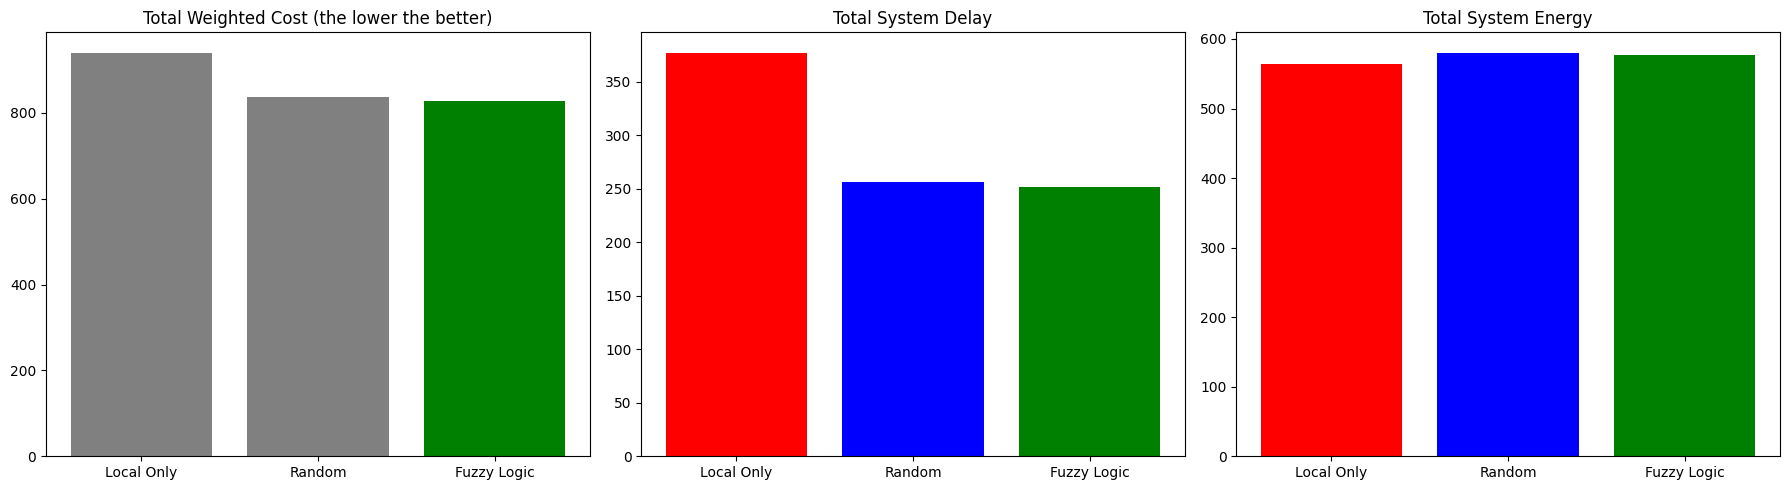

In [25]:
agents = {
    "Local Only": LocalOnlyAgent,
    "Random": RandomAgent,
    "Fuzzy Logic": FuzzyAgent 
}

print(f"{'Agent':<25} | {'Cost':<10} | {'Delay':<10} | {'Energy':<10}")
print("-" * 65)

results_cost = {}
results_delay = {}
results_energy = {}

for name, agent_cls in agents.items():
    cost, d, e = run_simulation(agent_cls)
    
    results_cost[name] = cost
    results_delay[name] = d
    results_energy[name] = e
    
    print(f"{name:<25} | {cost:<10.1f} | {d:<10.1f} | {e:<10.1f}")

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].bar(results_cost.keys(), results_cost.values(), color=['gray', 'gray', 'green'])
ax[0].set_title("Total Weighted Cost (the lower the better)")

ax[1].bar(results_delay.keys(), results_delay.values(), color=['red', 'blue', 'green'])
ax[1].set_title("Total System Delay")

ax[2].bar(results_energy.keys(), results_energy.values(), color=['red', 'blue', 'green'])
ax[2].set_title("Total System Energy")

plt.tight_layout()
plt.show()